In [1]:
import os, sys, json, copy, random, pickle, time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# set to my fork with fix on server
# sys.path.insert(0, '../../../myfastai')
# set to dev-head on local
sys.path.insert(0, '../../../fastaif')
import fastai
print(fastai.__version__)

from fastai.vision import *
from fastai.utils.mem import  gpu_mem_get_free_no_cache

%reload_ext autoreload
%autoreload 2

from modules.ap3data import build_data
from modules.ap3graph import pred_cmp_viz

from modules.miscutils import ( scp_from_gcloud
                               ,move_file_obj
                               ,fastai_version
                              )
from modules.modeleval import ( calc_sse
                               ,calc_mse
                               ,err_to_np
                               ,ModelHome
                               ,Residuals
                              )

1.0.53.dev0


In [2]:
# the two datasets for apfit2-X models

data_small = build_data(batch_size=16, 
                        size=(216, 324), 
                        valid_pct=0.2,
                        )
data_large = build_data(batch_size=16, 
                        size=(288, 432), 
                        valid_pct=0.2,
                        )

all validations pass
all validations pass


##### Copied down model artifacts

In [3]:
scp_from_gcloud('new-models/apfit2a*', 'new-models/')

running popen and waiting...
new files in dest (new-models/)
apfit2a-1.csv
apfit2a-1.pth
apfit2a-2.csv
apfit2a-2.pth
apfit2a-3.csv
apfit2a-3.pth
apfit2a-4.csv
apfit2a-4.pth
apfit2a-5.csv
apfit2a-5.pth


In [4]:
scp_from_gcloud('misc-data/*apfit2a*', 'misc-data/')

running popen and waiting...
new files in dest (misc-data/)
preds_apfit2a-1.pickle
preds_apfit2a-2.pickle
preds_apfit2a-3.pickle
preds_apfit2a-4.pickle
preds_apfit2a-5.pickle


##### Build ModelHome's for each

In [3]:
m1 = ModelHome(
                model_arch=models.resnet50,
                dataset=data_large,
                pth_fn='new-models/apfit2-1.pth',
                name='apfit2-1',
                history_fn='new-models/apfit2-1.csv',
                preds_fn='misc-data/preds-apfit2-1.pickle',
                )

In [11]:
m1

apfit2-1
        valid_err:          tensor(0.0103)
        training_err:       not implemented
        avg predict time:   None
        histroy loaded:     true
        (validation) preds loaded: true
        (training) preds loaded:   not implemented

In [10]:
m4 = ModelHome(
                model_arch=models.resnet34,
                dataset=data_small,
                pth_fn='new-models/apfit2-4.pth',
                name='apfit2-4',
                history_fn='new-models/apfit2-4.csv',
                preds_fn='misc-data/preds-apfit2-4.pickle',
                )

In [12]:
m4

apfit2-4
        valid_err:          tensor(0.0146)
        training_err:       not implemented
        avg predict time:   None
        histroy loaded:     true
        (validation) preds loaded: true
        (training) preds loaded:   not implemented

##### Use Helper Classes

In [81]:
from modules.modeleval import GroundTruth, Predictions, Residuals

##### Residuals

In [31]:
r = Residuals(m1.preds[2])

In [33]:
r.flow[:3]

tensor([1.4344e-05, 5.2166e-05, 1.1334e-03])

In [34]:
r.flow_np[:2,:]

array([[1.434393e-05, 5.216628e-05, 1.133397e-03, 7.303145e-04, 1.511035e-04, 1.277899e-03, 6.698055e-05,
        7.466799e-05],
       [6.865222e-03, 3.297965e-03, 7.751561e-03, 3.870893e-03, 2.575053e-04, 5.802845e-03, 1.050711e-04,
        3.981262e-03]])

In [35]:
r.get_loss(1)

0.03193232316698413

In [36]:
r.get_loss(1, per_coord=True)

array([0.006865, 0.003298, 0.007752, 0.003871, 0.000258, 0.005803, 0.000105, 0.003981])

In [38]:
r.get_loss().shape, r.get_loss(per_coord=True).shape

((1165,), (1165, 8))

##### GroundTruth

In [82]:
gt = GroundTruth(m1.preds[1])

In [84]:
gt.order

(3, 2, 1, 0)

In [93]:
gt.verify_order()

order at ind 14 is (2, 1, 0, 3) not (3, 2, 1, 0) 
 y_flow:
 tensor([[-0.0602,  0.0386],
        [ 0.2685,  0.0540],
        [ 0.2801, -0.0478],
        [-0.0208, -0.0602]])


False

In [96]:
misordered = gt.verify_order(ret_all=True)
len(misordered)

79

In [97]:
79 / len(m1.dataset.valid_dl.items)

0.06781115879828326

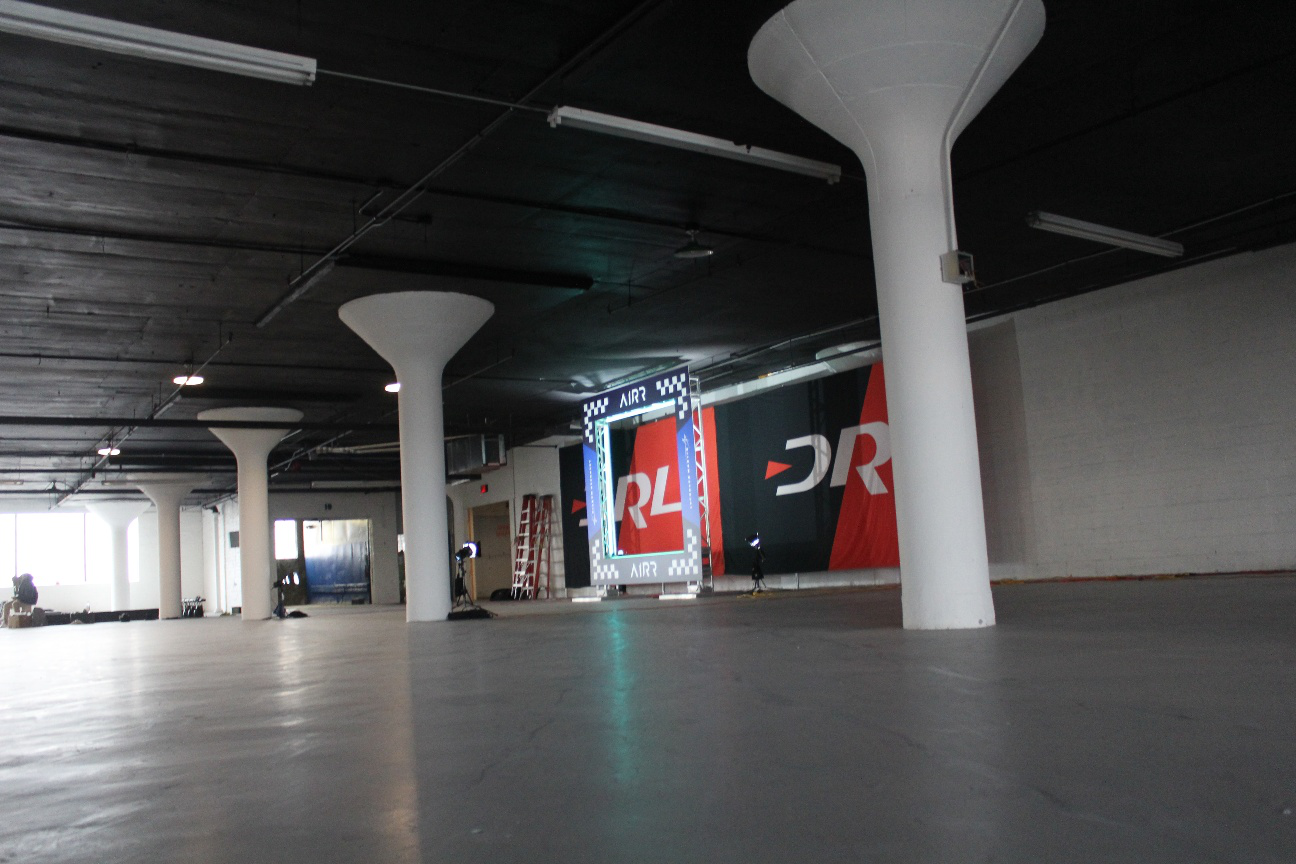

In [92]:
img = m1.dataset.valid_dl.x.get(14)
img

In [78]:
m1.preds[1][0]

tensor([[ 0.0023, -0.1065],
        [-0.0185,  0.0648],
        [ 0.3241,  0.0679],
        [ 0.3218, -0.1034]])

In [66]:
ay, ax = a[:,0], a[:,1]
print(ay,ax,sep='\n')

tensor([ 0.0023, -0.0185,  0.3241,  0.3218])
tensor([-0.1065,  0.0648,  0.0679, -0.1034])


In [71]:
y_sort = sorted(enumerate(ay), key=lambda e:e[1])
y_sort = [e[0] for e in y_sort]
y_lo, y_hi = y_sort[:2], y_sort[2:]
y_lo, y_hi

([1, 0], [3, 2])

In [72]:
x_sort = sorted(enumerate(ax), key=lambda e:e[1])
x_sort = [e[0] for e in x_sort]
x_lo, x_hi = x_sort[:2], x_sort[2:]
x_lo, x_hi

([0, 3], [1, 2])

In [74]:
tl = [e for e in range(4) if e in x_lo and e in y_hi][0]
tr = [e for e in range(4) if e in x_hi and e in y_hi][0]
br = [e for e in range(4) if e in x_hi and e in y_lo][0]
bl = [e for e in range(4) if e in x_lo and e in y_lo][0]
(tl, tr, br, bl)

(3, 2, 1, 0)

##### Use pred_cmp_viz()
there are three ways shown here:

 - on validation set, with known i-value
 - on training set , with random i-value
 - calc'ing then passing in list_preds, not list_mh

In [104]:
# validation index outcomes

# bad ones:
# 1110 - bad miss for good model
# 1008 - bad miss for both
# 649 - bad miss both
# 390 - bad miss both
# 755 - worst model regression from bad-model to good-model

# good ones:
# 0 - good for good-model, bad for bad-model
# 70 is decent
# 919 - decent for both
# 558
# 216 - excellent for both

#training index outcomes
#390 - good
#672 - decent

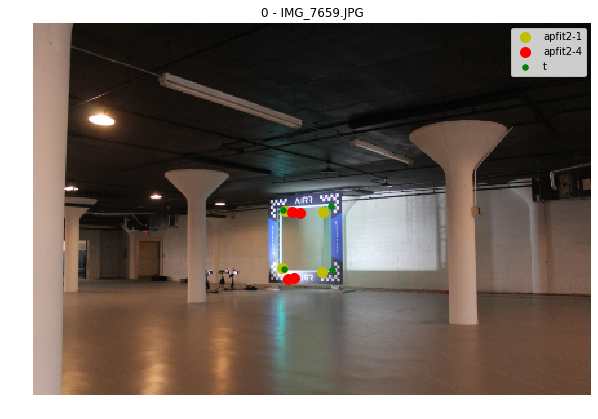

In [15]:
# compare on training set
pred_cmp_viz([m1, m4], add_truth = True, legend=True, i=0 )

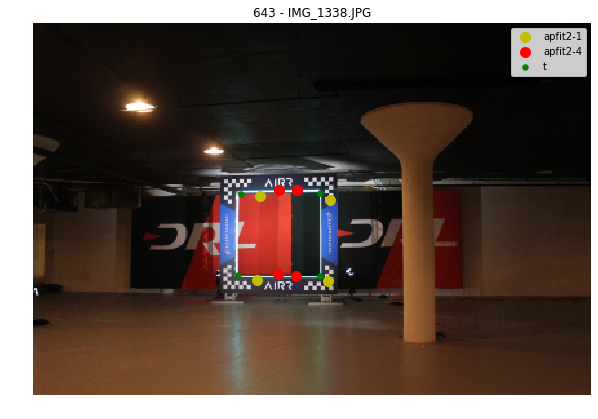

In [112]:
#trainers
pred_cmp_viz( list_mh = [m1, m4]
             ,add_truth = True
             ,legend=True
             ,b_train=True
             ,i=None
            )

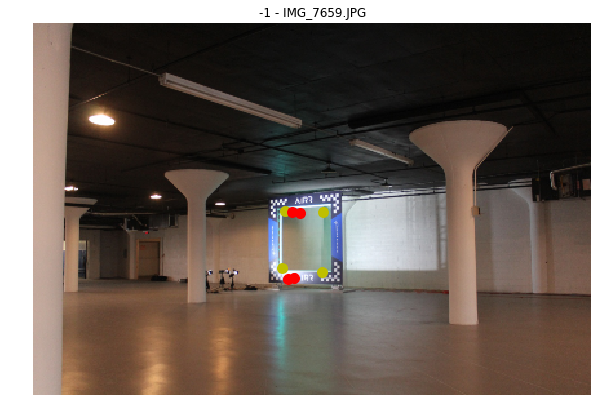

In [107]:
# pass-in prediction inputs
img0 = m1.dataset.valid_dl.get(0)
fn0 = m1.dataset.valid_dl.items[0]
preds = [m1.model.predict(img0)[2], m4.model.predict(img0)[2]]

pred_cmp_viz(list_mh=None,i=-1,list_preds=preds,preds_input=(fn0,img0))